In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 8.4 MB/s eta 

In [ ]:
import tensorflow as tf
import gradio as gr
import numpy as np
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=5

In [ ]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Datasets/PlantVillage',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 3 classes.


In [ ]:
# Access class names
class_names = dataset.class_names
print(class_names)

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']


Image Batch size:  (32, 256, 256, 3)
Lables in one batch size: 
 [2 2 0 2 2 1 1 0 0 0 1 2 1 1 0 2 2 1 2 0 1 2 2 1 1 2 1 1 1 1 0 2]


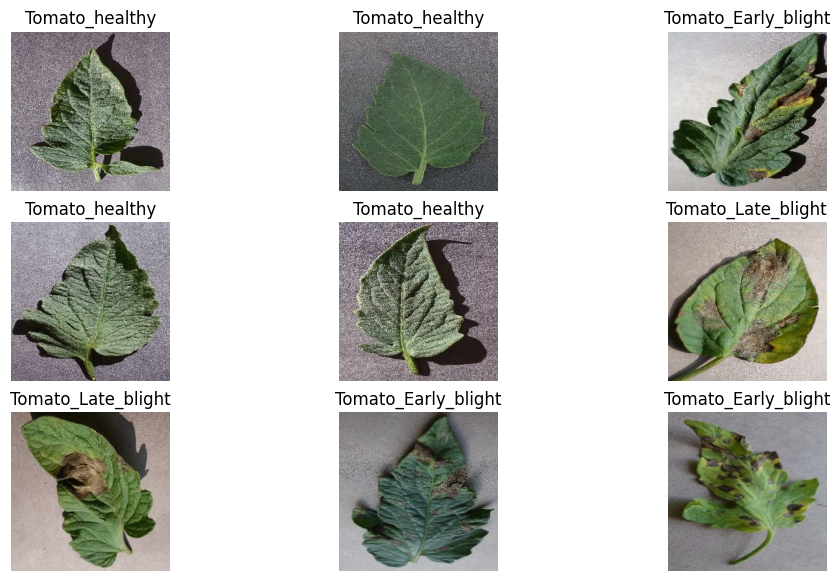

In [ ]:
#Reading image
plt.figure(figsize=(12,7))
for image_batch, label_batch in dataset.take(1):
    print('Image Batch size: ',image_batch.shape)
    print('Lables in one batch size: \n',label_batch.numpy())

    for i in range(9):
        sub = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [ ]:
#Data Preprocessing and Augmentation
def get_partitions_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):

    assert(train_split+val_split+test_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=0)


    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds, val_ds, test_ds

In [ ]:
# Using cache and prefetch


train_ds, val_ds, test_ds = get_partitions_dataset(dataset)


train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Resize and rescale

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)])

In [ ]:
# Data Augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1)])

In [ ]:
#Model creation and training
#Model Architecture

input1 = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([

    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')

])

model.build(input_shape=input1)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 256, 256, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 128, 128, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 128, 128, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 64, 64, 64)          0         
 g2D)                                                 

In [ ]:
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy']
             )

In [ ]:
#Training

history = model.fit(train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=1)

Epoch 1/5
75/75 [==============================] - 628s 5s/step - loss: 0.8259 - accuracy: 0.6166 - val_loss: 0.9769 - val_accuracy: 0.6215
Epoch 2/5
75/75 [==============================] - 367s 5s/step - loss: 0.4038 - accuracy: 0.8298 - val_loss: 0.5110 - val_accuracy: 0.8229
Epoch 3/5
75/75 [==============================] - 347s 5s/step - loss: 0.4049 - accuracy: 0.8374 - val_loss: 0.6665 - val_accuracy: 0.8090
Epoch 4/5
75/75 [==============================] - 363s 5s/step - loss: 0.3181 - accuracy: 0.8771 - val_loss: 0.5383 - val_accuracy: 0.8229
Epoch 5/5
75/75 [==============================] - 359s 5s/step - loss: 0.2490 - accuracy: 0.9026 - val_loss: 0.4974 - val_accuracy: 0.8576


In [ ]:
# Save the model to Google Drive
model.save('/content/drive/My Drive/Tomato.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#Model Evaluation
scores=model.evaluate(test_ds)

10/10 [==============================] - 26s 1s/step - loss: 0.5964 - accuracy: 0.8269


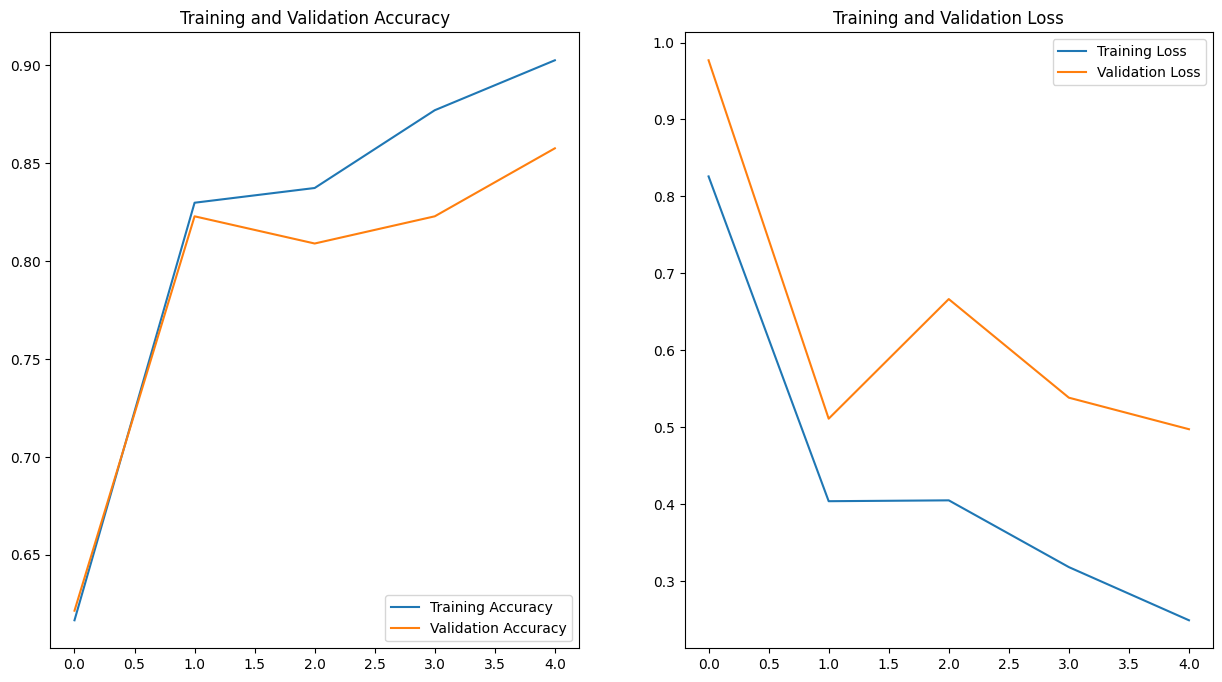

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual flower:  Tomato_Late_blight
1/1 [==============================] - 2s 2s/step
Predicted Flower:  Tomato_healthy


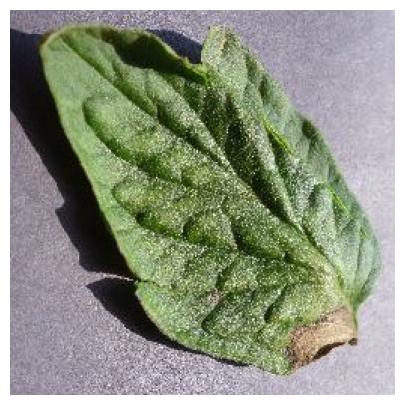

In [ ]:
#Prediction
import numpy as np
plt.figure(figsize=(8,5))
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    print('First image to predict')
    plt.imshow(first_image)
    print('Actual flower: ', class_names[label_batch[0].numpy()])

    batch_prediction = model.predict(image_batch)
    print('Predicted Flower: ',class_names[np.argmax(batch_prediction[0])])
    plt.axis('off')